<div class="alert alert-block alert-info"><h3>IFN619 Assignment 1 Part B</h4></div>

In [1]:
# import the library for both Q2 and Q3

# for data loading and cleaning
import numpy as np                  
import pandas as pd             
import sys
!{sys.executable} -m pip install nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter

# for Bayesan Networks (BNs)
import os
import math
import pyAgrum as bn_graphs
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC

# for Topic Classification and Topic Modelling
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution
from pprint import pprint
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
import pickle

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# for Visualisation
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns           
sns.set()
!{sys.executable} -m pip install WordCloud
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Question 2
What do housing-market indicators say about the socio-economic conditions in different geographical locations, and how can they be used to provide forecasts of future economic conditions?  

<img src="img/house.jpg" />

## 1. Introduction
Lee is a CEO of the Chinese investment company which is focusing on real estate investment in China. The company achieved a great success in their investments in China market over the last 5 years. In 2020, Lee would like to expand their business to overseas. However, the travelling plan for market research and investigation is limited due to the outbreak of COVID-19 around the world. Lee still expects to know if the economic recession will affect the housing price in different countries. As he known, the unemployment rate is rapidly increasing during this period, so he is more interested in how does the unemploymnet rate impact the housing prices and how do the housing prices reflect the economic conditions, so that he could make a decision for his following investment strategies overseas.       
As a member of the investment analysis team, we are provided the data from G7 coutries and Australia to solve these problems.

### 1.1 Scope
- Only G7 countries and Australia will be covered in this analysis given the provided data.  
- The elements consist of housing prices index (HPI), the unemployment rate, the interest rate, GDP and CPI only as provided in the data.

### 1.2 Stakeholder(s)
Chinese investment company which wants to invest in real estate overseas.

### 1.3 Questions
- Will the economic recession affect the housing price in different countries?
- Do the house prices reflect the socio-economic conditions in different countries and how?
- Does the unemployment rate impact on the housing market and how?
- Can the housing-market indicators be used to forecast the future economic conditions and how?

### 1.4 Approach

<img src="img/process.png" />
<center>source: ifn619 lecture</center>

## 2. Data

### 2.1 Collect / Load Data
The Data provided in this analysis is collected from [OECD](https://en.wikipedia.org/wiki/OECD) (Organisation for Economic Co-operation and Development): https://data.oecd.org/ 
- [Norminal Housing Prices (HPI)](https://data.oecd.org/price/housing-prices.htm)(Index with base year 2015)
- [Inflation (CPI)](https://data.oecd.org/price/inflation-cpi.htm#indicator-chart)(annual growth rate %)
- [Long-term Interest Rate (Interest Rate)](https://data.oecd.org/interest/long-term-interest-rates.htm)(% per annum)
- [Quarterly GDP (GDP)](https://data.oecd.org/gdp/quarterly-gdp.htm#indicator-chart)(% change, previous period)
- [Unemployment Rate](https://data.oecd.org/unemp/unemployment-rate.htm#indicator-chart)(% of labor force)


OECD, as an intergovernmental organisation, is regared as a trustworthy source of the data in this analysis with good data quality which will lead a more effective analysis here.

In [2]:
# load the data
eco = pd.read_csv("RawData/EcoData.csv")
eco = eco.round(2)
eco

,COUNTRY,YEAR,QR,UNEMP,INTRATE,GDP,CPI,HPI
0,AUS,1999,Q4,6.63,6.63,1.70,1.92,32.19
1,AUS,2000,Q1,6.65,6.90,0.38,2.80,32.91
2,AUS,2000,Q2,6.30,6.30,0.92,3.08,33.55
3,AUS,2000,Q3,5.99,6.18,0.19,6.11,33.62
4,AUS,2000,Q4,6.17,5.88,-0.38,5.79,34.31
...,...,...,...,...,...,...,...,...
643,USA,2018,Q4,3.80,3.03,0.27,2.20,122.25
644,USA,2019,Q1,3.87,2.65,0.77,1.64,123.93
645,USA,2019,Q2,3.63,2.33,0.50,1.81,125.36
646,USA,2019,Q3,3.63,1.80,0.52,1.76,126.88


In [3]:
# get the dimensions of your dataset
dimensions = eco.shape

print( 'General size of the dataset: ' + str( dimensions ))

# extract the number of rows and columns from your data
num_rows = dimensions[0]
num_col  = dimensions[1]
print('The dataset has ' + str( num_rows ) + ' rows and ' + str( num_col ) + ' columns.' )


General size of the dataset: (648, 8)
The dataset has 648 rows and 8 columns.


In [4]:
# which years are covered in this dataset?
year = eco.loc[:, "YEAR"].unique()
print(year)

[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]


### 2.2 Data Cleaning

In [5]:
# to make the country name more readable
country =set(eco.COUNTRY)
eco.replace({'AUS':'Australia','CAN':'Canada',
             'DEU':'Germany','FRA':'France',
             'GBR':'United Kingdom','ITA':'Italy',
            'JPN':'Japan','USA':'United States'},inplace=True)

In [6]:
country =set(eco.COUNTRY)
print("There are total "+str(len(country))+" countries. \nThey are "+str(country))

There are total 8 countries. 
They are {'France', 'Canada', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States', 'Australia'}


More data cleaning will be executed as required by the analysis and visualisation in the following sections.

## 3. Data Re-Cleaning, Analysis & Visualisation

As there are different requirements of data cleaning for the analysis, to make it clearer to understand, the following analysis are orgnised in order as below,
1) **HPI (House Price Index) Analysis** by country groups: data re-cleaning -> analysis & visualisation   
2) **Causal Analysis:** data re-cleaning -> data modelling -> analysis & visualisation

### 3.1 HPI Analysis
Firstly, we will analyse the housing price trend in these countries.

#### 3.1.1 Data Re-cleaning

In [7]:
# we're going to generalise the data into years 
# and then have a overview of the housing-market in these year by plot.
annual_data=eco.groupby(['YEAR','COUNTRY']).mean()
annual_data.to_csv('annual_data.csv')
annual_data=pd.read_csv('annual_data.csv')
annual_data

,YEAR,COUNTRY,UNEMP,INTRATE,GDP,CPI,HPI
0,1999,Australia,6.6300,6.6300,1.7000,1.9200,32.190000
1,1999,Canada,6.9700,6.0900,1.4100,2.3700,38.940000
2,1999,France,NaN,5.2800,1.3700,0.9900,46.500000
3,1999,Germany,8.2200,5.1600,0.7900,0.9500,84.370000
4,1999,Italy,11.0700,5.3800,1.5000,2.0900,66.430000
...,...,...,...,...,...,...,...
163,2019,Germany,3.1400,-0.2500,0.1175,1.4450,128.080000
164,2019,Italy,9.9500,1.9525,0.0250,0.6125,98.516667
165,2019,Japan,2.3600,-0.1100,-0.1675,0.4775,108.652500
166,2019,United Kingdom,3.7375,0.9350,0.2625,1.7500,116.945000


In [8]:
# change the type of the "YEAR" for plot
annual_data['YEAR'] = pd.to_datetime(annual_data['YEAR'].astype(str), format='%Y')

#### 3.1.2 Analysis & Visualisation

Text(0.5, 0, 'Year')

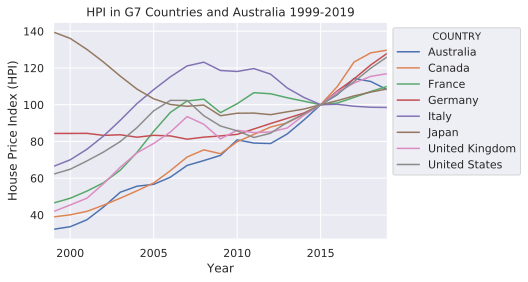

In [9]:
annual_hpi = annual_data.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
plot = annual_hpi.plot(title = 'HPI in G7 Countries and Australia 1999-2019')
plot.get_legend().set_bbox_to_anchor((1, 1))
plot.set_ylabel('House Price Index (HPI)')
plot.set_xlabel('Year')

In [10]:
#HPI gathered at the same point in 2015 because the index data was collected with the base year 2015 as mentioned at the beginning.

Here above, we got a general view of the housing price trend from 1999 to 2019. But the lines are complex to interpret in this plot. So how about trying plot it by country groups?  

We divide these 8 countries into 3 groups:
- Commonwealth countries: Australia, Canada, UK
- European countries: France, Germany, Italy
- Others: US, Japan

Let's see..

Text(0.5, 0, 'Year')

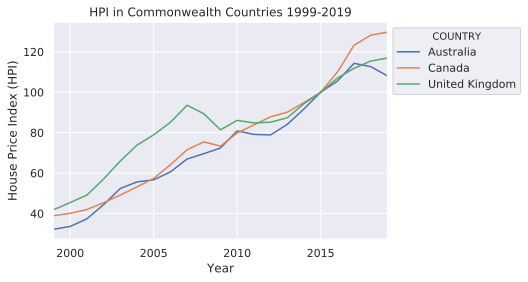

In [11]:
comm = annual_data.loc[annual_data['COUNTRY'].isin(['Australia','Canada','United Kingdom'])]
comm_hpi = comm.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
comm_plot = comm_hpi.plot(title = 'HPI in Commonwealth Countries 1999-2019')
comm_plot.get_legend().set_bbox_to_anchor((1, 1))
comm_plot.set_ylabel('House Price Index (HPI)')
comm_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> Housing price indexes in commonwealth countries were mostly in the similar pattern from 1999 to 2017, but Australia went to a different direction around 2018, the HPI increased in Canada and UK while it decreased in Australia mainly driven by the price drops in Sydney and Melbourne. The decreasing trend was due to the decreased investors' demand. However, the changes might differ across the nation as explained in The Guardian (e.g. the house price had a rapid increase in Hobart at that time.)
    </div>

[Sydney and Melbourne housing price falls reach lower end of market](https://www.theguardian.com/australia-news/2018/dec/11/sydney-and-melbourne-housing-price-falls-reach-lower-end-of-market)

How were the HPIs going in European countries?

Text(0.5, 0, 'Year')

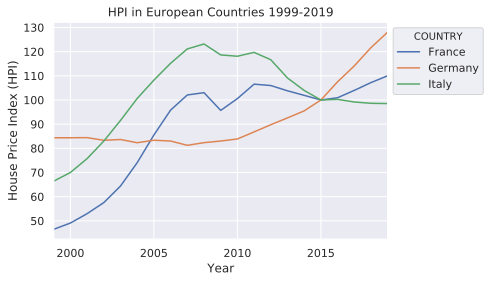

In [12]:
euro = annual_data.loc[annual_data['COUNTRY'].isin(['France','Germany','Italy'])]
eu_hpi = euro.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
eu_plot = eu_hpi.plot(title = 'HPI in European Countries 1999-2019')
eu_plot.get_legend().set_bbox_to_anchor((1, 1))
eu_plot.set_ylabel('House Price Index (HPI)')
eu_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> The pattern in France and Italy was a bit similar during 1999-2015 but were poles apart from 2015, while the house prices in Germany kept increasing from 1999 and shown a strong rise from 2015 due to the unique real estate financial policies and sophisticated rental market (Voigtländer, 2014).
    </div>

How about other countries in this dataset?

Text(0.5, 0, 'Year')

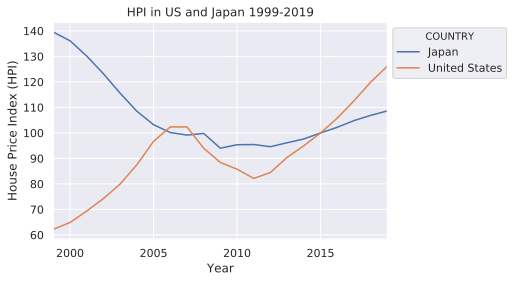

In [13]:
others = annual_data.loc[annual_data['COUNTRY'].isin(['United States','Japan'])]
oth_hpi = others.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
oth_plot = oth_hpi.plot(title = 'HPI in US and Japan 1999-2019')
oth_plot.get_legend().set_bbox_to_anchor((1, 1))
oth_plot.set_ylabel('House Price Index (HPI)')
oth_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> 
    <li>HPI has not been stable in the US since 1999, but it can be easily associated with the Global Financial Crisis (GFC) between 2007 to 2009 because of the housing bubble, and the house price continued to decline till 2011 reflected the huge impacts of GFC. However, there has been a sustainable growth since 2012 which might be attributed from the fiscal stimulus. But no one will know if there will be another housing bubble then.
    <li>The drop of the house price in Japan started from 1999 should be traced back to its "Lost Decade" from 1991, but it seems there was a sign of recovery from 2012. 
    </div>

[The Global Financial Crisis](https://www.rba.gov.au/education/resources/explainers/pdf/the-global-financial-crisis.pdf?v=2020-04-21-01-30-03)<br>
[Japan's Lost Decade](https://www.adb.org/sites/default/files/publication/159841/adbi-wp521.pdf)

We could have some insights about how HPI reflects the general socio-economic conditions as above, what are other indicators such as unemployment rate, interest rate, GDP and CPI saying about the economic conditions compared to HPI in different countries? 

### 3.2 Causul Analysis
To discover what is the relationship between the indicators, how does the unemployment rate affect the housing market and figure out if the indicators involved in this analysis can forecast the future economic conditions. The causal analysis is conducted in this part by building a [Bayesian Network](https://www.bayesserver.com/docs/introduction/bayesian-networks).<br>The **Bayesian Network** in this part could help us to make inferences to estimate the indicators' impacts by representing a probabilistic causal model between each indicator.

#### 3.2.1 Data Re-cleaning
More data cleaning is needed as we are going to figure out how will HPI changes be affected by or reflect other indicators' changes.

In [14]:
# calculate the changes of the indicator from previous quarter
# as GDP is decribing the % of changes compared to previous period, so no need to do this for GDP
eco1 = eco.drop(['COUNTRY','YEAR','QR','GDP'],axis=1)
eco_diff = eco1.diff()
eco_diff

,UNEMP,INTRATE,CPI,HPI
0,NaN,NaN,NaN,NaN
1,0.02,0.27,0.88,0.72
2,-0.35,-0.60,0.28,0.64
3,-0.31,-0.12,3.03,0.07
4,0.18,-0.30,-0.32,0.69
...,...,...,...,...
643,0.03,0.10,-0.44,1.55
644,0.07,-0.38,-0.56,1.68
645,-0.24,-0.32,0.17,1.43
646,0.00,-0.53,-0.05,1.52


In [15]:
# make the new dataframe filled with changes of each indicator from previous quarter (e.g. 2000/Q1-1999/Q4)
eco2 = eco.drop(['UNEMP','INTRATE','CPI','HPI'],axis=1)
new_eco = pd.concat([eco2,eco_diff],axis=1)
new_eco

,COUNTRY,YEAR,QR,GDP,UNEMP,INTRATE,CPI,HPI
0,Australia,1999,Q4,1.70,NaN,NaN,NaN,NaN
1,Australia,2000,Q1,0.38,0.02,0.27,0.88,0.72
2,Australia,2000,Q2,0.92,-0.35,-0.60,0.28,0.64
3,Australia,2000,Q3,0.19,-0.31,-0.12,3.03,0.07
4,Australia,2000,Q4,-0.38,0.18,-0.30,-0.32,0.69
...,...,...,...,...,...,...,...,...
643,United States,2018,Q4,0.27,0.03,0.10,-0.44,1.55
644,United States,2019,Q1,0.77,0.07,-0.38,-0.56,1.68
645,United States,2019,Q2,0.50,-0.24,-0.32,0.17,1.43
646,United States,2019,Q3,0.52,0.00,-0.53,-0.05,1.52


In [16]:
# all the changes are NaN in Q4,1999 as there is no data provided here in Q3,1999 for calculation which are meaningless.
# so remove all the data in Q4,1999, we do the analysis from 2000 to 2019 then.
new_eco = new_eco.drop(new_eco[new_eco.YEAR == 1999].index)
new_eco

,COUNTRY,YEAR,QR,GDP,UNEMP,INTRATE,CPI,HPI
1,Australia,2000,Q1,0.38,0.02,0.27,0.88,0.72
2,Australia,2000,Q2,0.92,-0.35,-0.60,0.28,0.64
3,Australia,2000,Q3,0.19,-0.31,-0.12,3.03,0.07
4,Australia,2000,Q4,-0.38,0.18,-0.30,-0.32,0.69
5,Australia,2001,Q1,1.02,0.20,-0.59,0.24,0.92
...,...,...,...,...,...,...,...,...
643,United States,2018,Q4,0.27,0.03,0.10,-0.44,1.55
644,United States,2019,Q1,0.77,0.07,-0.38,-0.56,1.68
645,United States,2019,Q2,0.50,-0.24,-0.32,0.17,1.43
646,United States,2019,Q3,0.52,0.00,-0.53,-0.05,1.52


In [17]:
# same with HPI analysis, the analysis will be executed year by year 
new = new_eco.groupby(["COUNTRY","YEAR"]).mean()
new.to_csv("new_eco.csv")
data = pd.read_csv("new_eco.csv")

# tag the HPI with 0 and 1 so that we could make inferences afterwards
# 1 - increase (positive HPI changes); 0 - decrease (negative HPI changes)
data['HPI_Tag'] = np.where(data['HPI']>0,1,np.where(data['HPI']<0,0,np.nan))
data 

,COUNTRY,YEAR,GDP,UNEMP,INTRATE,CPI,HPI,HPI_Tag
0,Australia,2000,0.2775,-0.1150,-0.1875,0.9675,0.5300,1.0
1,Australia,2001,1.0625,0.2025,-0.0800,-0.6600,1.3150,1.0
2,Australia,2002,0.8775,-0.2050,-0.0100,-0.0575,1.8350,1.0
3,Australia,2003,0.9550,-0.1125,0.0575,-0.1175,2.2100,1.0
4,Australia,2004,0.7500,-0.1475,-0.1025,0.0175,0.0375,1.0
...,...,...,...,...,...,...,...,...
155,United States,2015,0.4700,-0.1675,-0.0225,-0.1950,1.3475,1.0
156,United States,2016,0.5025,-0.0650,-0.0150,0.3325,1.5500,1.0
157,United States,2017,0.6900,-0.1600,0.0600,0.0800,1.7775,1.0
158,United States,2018,0.6225,-0.0825,0.1650,0.0200,1.7150,1.0


<div class="alert alert-block alert-warning">
<b>Note:</b> Use "HPI_Tag" to tag the HPI changes: 1 - Increase, 0 - Decrease
</div>

In [18]:
# check the missing value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
COUNTRY    160 non-null object
YEAR       160 non-null int64
GDP        160 non-null float64
UNEMP      157 non-null float64
INTRATE    160 non-null float64
CPI        160 non-null float64
HPI        160 non-null float64
HPI_Tag    160 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


In [19]:
# fill the missing value by mean, this might affect the analysis result a bit
data['UNEMP'].fillna(data['UNEMP'].mean(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
COUNTRY    160 non-null object
YEAR       160 non-null int64
GDP        160 non-null float64
UNEMP      160 non-null float64
INTRATE    160 non-null float64
CPI        160 non-null float64
HPI        160 non-null float64
HPI_Tag    160 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


In [20]:
# Bayesian networks only support discrete values, they are not able to deal with continuous variables
# so use this function to discretise the data

def discretize_dataframe( df, num_bins, class_var ):
    r=np.array(range(num_bins+1))/(1.0*num_bins)
  
    # quantiles are building using pandas.qcut
    # The "class" column is just copied.
    l=[]
    
    for col in df.columns.values:
        
        if col!=class_var:
            l.append(  pd.DataFrame( pd.qcut( df[col],r, duplicates='drop',precision=2),columns=[col]))
        else:
            l.append( pd.DataFrame( np.round(df[col],2),columns=[col]))
    
    treated=pd.concat(l, join='outer', axis=1)
    return treated

In [21]:
# discretise the data
num_bins = 4

variables_to_discretize = data[["UNEMP", "INTRATE", "GDP", "CPI", "HPI_Tag"]]

data_discr = discretize_dataframe(variables_to_discretize, num_bins, "HPI_Tag" )
data_discr["YEAR"] = data["YEAR"]
data_discr["COUNTRY"] = data["COUNTRY"]
data_discr.to_csv("discr_data.csv", index=False)

file_discr = "discr_data.csv"
data_discr = pd.read_csv(file_discr)
data_discr

,UNEMP,INTRATE,GDP,CPI,HPI_Tag,YEAR,COUNTRY
0,"(-0.41000000000000003, -0.12]","(-0.53, -0.13]","(0.2, 0.43]","(0.15, 0.97]",1.0,2000,Australia
1,"(0.043, 0.76]","(-0.13, -0.059]","(0.66, 1.25]","(-0.78, -0.14]",1.0,2001,Australia
2,"(-0.41000000000000003, -0.12]","(-0.059, 0.029]","(0.66, 1.25]","(-0.14, 0.0063]",1.0,2002,Australia
3,"(-0.12, -0.056]","(0.029, 0.6]","(0.66, 1.25]","(-0.14, 0.0063]",1.0,2003,Australia
4,"(-0.41000000000000003, -0.12]","(-0.13, -0.059]","(0.66, 1.25]","(0.0063, 0.15]",1.0,2004,Australia
...,...,...,...,...,...,...,...
155,"(-0.41000000000000003, -0.12]","(-0.059, 0.029]","(0.43, 0.66]","(-0.78, -0.14]",1.0,2015,United States
156,"(-0.12, -0.056]","(-0.059, 0.029]","(0.43, 0.66]","(0.15, 0.97]",1.0,2016,United States
157,"(-0.41000000000000003, -0.12]","(0.029, 0.6]","(0.66, 1.25]","(0.0063, 0.15]",1.0,2017,United States
158,"(-0.12, -0.056]","(0.029, 0.6]","(0.43, 0.66]","(0.0063, 0.15]",1.0,2018,United States


#### 3.2.2 Data Modelling

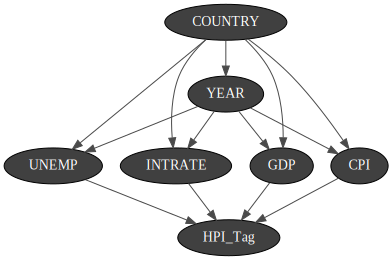

In [22]:
# call a Bayesian Network learner with the learning algorithm: the Hill Climbing algorithm
# different algorithm might lead to a different Bayesian Network
learner = gum.BNLearner(file_discr)
learner.useGreedyHillClimbing()
learner.addMandatoryArc("COUNTRY","YEAR") 
learner.addMandatoryArc("YEAR", "UNEMP") 
learner.addMandatoryArc("COUNTRY", "UNEMP") 
learner.addMandatoryArc("YEAR", "INTRATE") 
learner.addMandatoryArc("COUNTRY", "INTRATE") 
learner.addMandatoryArc("YEAR", "GDP") 
learner.addMandatoryArc("COUNTRY", "GDP")
learner.addMandatoryArc("YEAR", "CPI") 
learner.addMandatoryArc("COUNTRY", "CPI")
learner.addMandatoryArc("INTRATE","HPI_Tag") 
learner.addMandatoryArc("GDP","HPI_Tag") 
learner.addMandatoryArc("UNEMP","HPI_Tag") 
learner.addMandatoryArc("CPI","HPI_Tag") 
# learn the data
bn = learner.learnBN()
gnb.showBN(bn,size=100)

In [23]:
# extract the feature in the model
features = data_discr.drop(["HPI_Tag"], axis=1).columns.tolist()
features

['UNEMP', 'INTRATE', 'GDP', 'CPI', 'YEAR', 'COUNTRY']

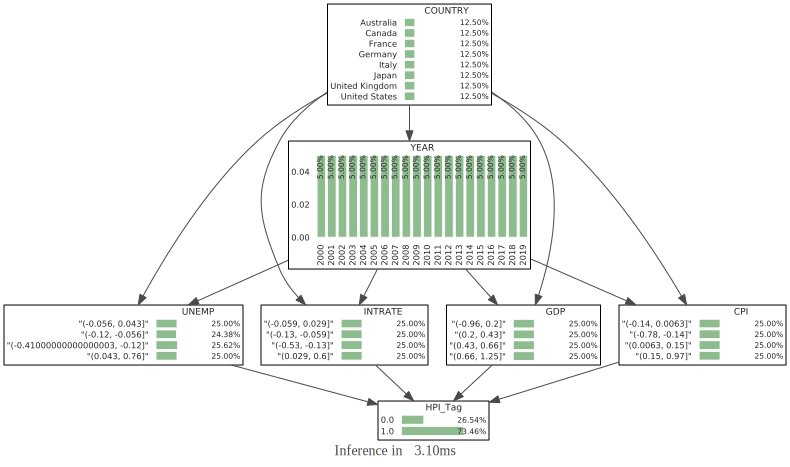

In [24]:
inference = bn_graphs.LazyPropagation(bn)
gnb.showInference(bn,inference, size=100)

Here above, we've built a Bayesian Network describing the probabilistic causal relationship between indicators. Moreover, both "COUNTRY" and "YEAR" are also counted into this network so that we could have a much clearer direction on which country was most affected by a specific indicator and in which year. The probabilities of the variables in each indicator are displayed in this model.

<div class="alert alert-block alert-success">
<b>Insight Note:</b> Generally, most of the house prices are increasing (73.43%) in these 8 countries from 2000 to 2019.
</div>

#### 3.2.3 Analysis & Visualisation

**Then let's initiate some questions to this network by calling the inference engine.**
* What if the HPI is 100% decreased (HPI_Tag set as 0)?

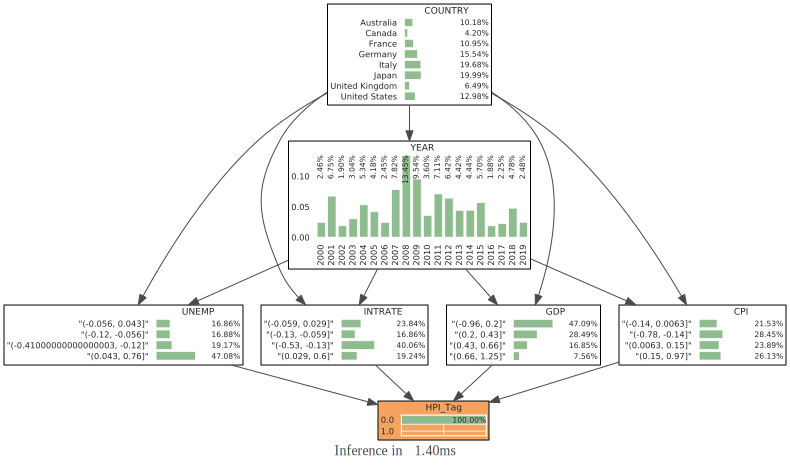

In [25]:
gnb.showInference( bn, inference, {'HPI_Tag':0} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b>
    <li>In terms of country in this model, Japan and Italy stand out of other counties, this is truly reflecting its economic recession over the past decades due to the housing bubble.
    <li>It can be identified the decreased housing prices occurred mainly in 2008 which is the year of Global Financial Recession.
    <li>For the indicators, the probabilities in the unemployment rates, the interest rates and GDP are showing significant changes: the unemployment rate is increasing with the decreasing of the interest rates and GDP.
    <li>So we would say the housing prices could reflect the economic conditions in some ways specially regarding to the unemployment rate, the interest rate and GDP. But the impacts on different countries might vary.
</div>

* As the main focus for the stakeholder, how does the unemployment rate perform in the model? let's see when unemployment is high.

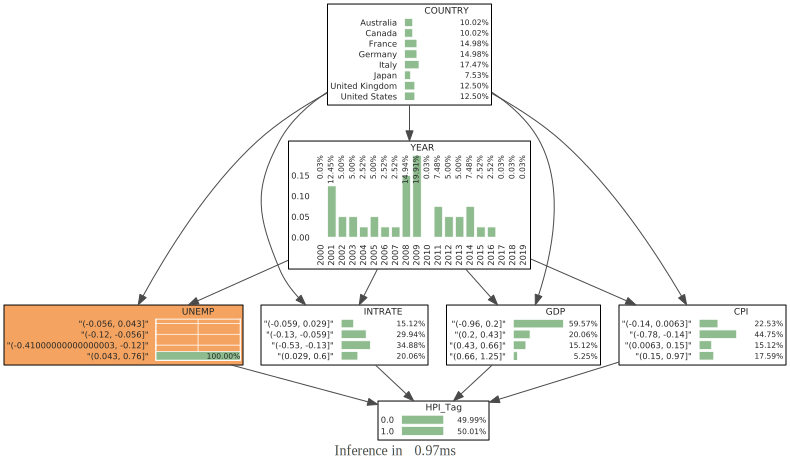

In [26]:
value = '"(0.043, 0.76]"'
gnb.showInference( bn, inference, { 'UNEMP' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> 
    <li>It is apparently showing that the high unemployment rates occurred in 2001, 2008 and 2019 especially in European countries (Italy, Germany and France). This might due to the economic recession in these years. According to CNBC and Investopedia, the 8-month recession of 2001 was mainly caused by the "Internet Bubble" as well as 9-11 attack, and the Global Financial Crisis of 2008-2009 was due to the housing bubble.
    <li>It can be noticed that there was a rapid decrease in housing price because of the unemployment rates, the number of the decreasing HPI increased around 25% from 26.57% to 50.04%.
    <li>CPI was also affected as the majority of the changes was staying negatively in the range of (-0.78,-0.14] because there was less money in people's pockets due to layoffs.
    <li>However, it seems Japan was not affected a lot compared to other countries as shown in the model. But the truth is the data is showing the changes by years. Actually, Japan had been experiencing its "Lost Decade" before 2001, so we would say, there had been no sign of recovery since 1991 in Japan and it didn't mean Japan was not affected by the recession.
             
</div>

[Investopedia: A Review of Past Recessions](https://www.investopedia.com/articles/economics/08/past-recessions.asp)<br>
[CNBC Explains: Recession](https://www.cnbc.com/id/43563081)
<br>[Japan's Lost Decade](https://www.adb.org/sites/default/files/publication/159841/adbi-wp521.pdf)

* What about the interest rate? let's see when interest rate is high.

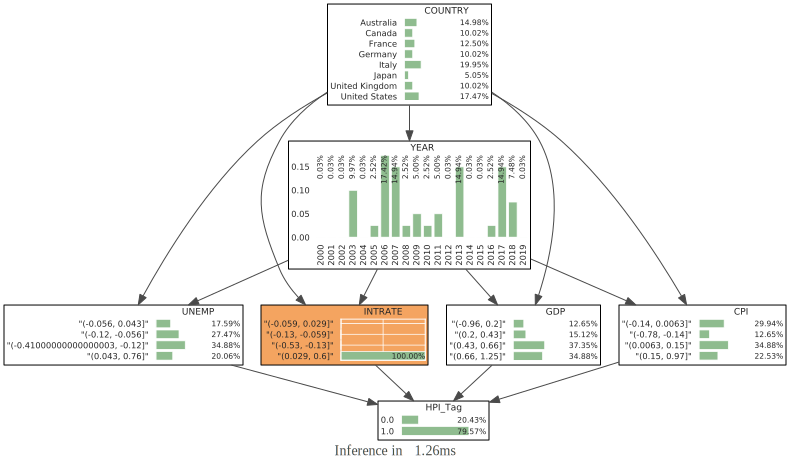

In [27]:
value = '"(0.029, 0.6]"'
gnb.showInference( bn, inference, { 'INTRATE' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> 
It can be noticed that even the interest rate increases as we set, we still get an increased probability in HPI_Tag:1, which means the housing prices increases in some years (2006-2007, 2013, 2017). The causes might be found in the decreasing unemployment rate (around 80% are negative changes). But it's still too early to eliminate the impacts of the interest rates given our limited resources in this analysis.
    </div>

* what if the GDP or the CPI is high?

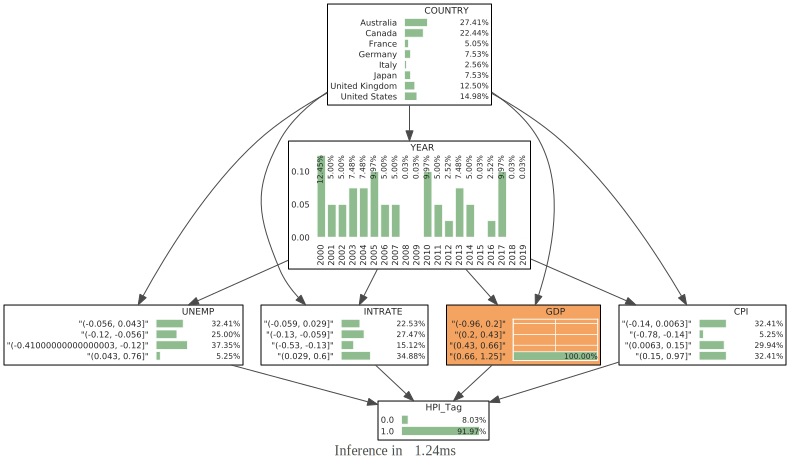

In [28]:
value = '"(0.66, 1.25]"'
gnb.showInference( bn, inference, { 'GDP' : value} ,size=100)

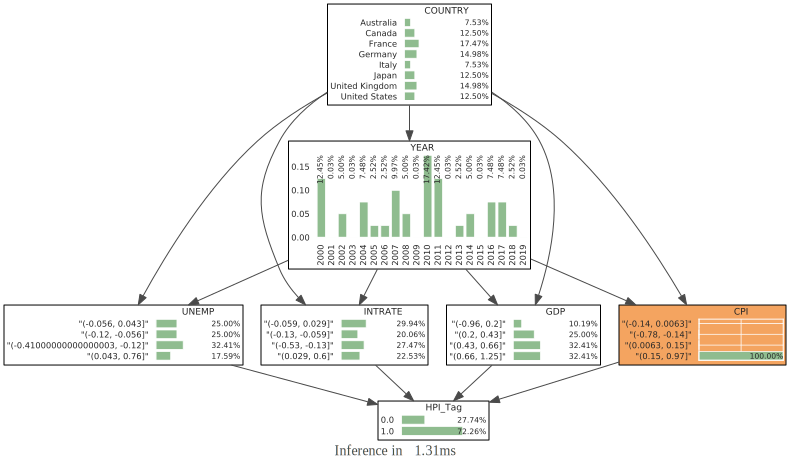

In [29]:
value = '"(0.15, 0.97]"'
gnb.showInference( bn, inference, { 'CPI' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> not so much indications can be be found from the model in terms of GDP and CPI setting here.
    </div>

### 4. Insights
- Generally, the economic recession has great impacts on the housing market especially when it comes to the Global Financial Crisis (GFC) during 2007-2009 except for Germany due to its unique real estate financial policies and sophisticated rental market.
- The house price trend varies in different countries and it is not only related to the economic indicators such as interest rate, but also the investors' demand from domestic to international perspectives (e.g. Australia).
- Local fiscal stimulus can drive changes in the housing market (e.g. the US). Likewise, the housing-market indicators such as HPI can reflect the governmental financial policies which are made in accordance with the current economic conditions. So, we would say there is a mutual effect between the housing market and the economic conditions.
- The house price can reflect the socio-economic conditions in the unemployment rate, the interest rate and GDP particularly. When the house price is decreasing, the unemployment rate usually shows increasing while the interest rate and GDP are decreasing, but not vice versa in this analysis.
- As concerned by the stakeholder, YES, the unemployment rate has significant influences on the housing market as well as CPI. When the unemployment rate is high, the CPI and the house price will usually decrease.
- Finally, the housing market indicators can be provided for forecasting the economic conditions to some extent. The house prices can be the reflection of the current state of the economy in a country, and some indicators such as the interest rate, the unemployment rate are both housing market indicators and the socio-economic indicators, and they could be interacted with each other. But regarding the real estate investment decision, it should be emphasised that the housing prices are not only affected by the socio-economic situations in a country, but also related to the house itself (the location, the area, the education catchment, the house type, etc.), the investment policy including but not limited to the taxes and even the local buying culture.

**Limitations and Future Work**
- The indicators selected in this anlysis are limited and more indicators can be involved in to achieve a more accurate analysis.
- Analysis results will vary from country to country, so once you have a target country, it might be better to focus on the specific situations in that country and take more factors into account in the analysis.
- The analysis results may also be different from each other due to the different techniques and algorithms applied in the analysis. So, it should be better to evaluate the result using professional methods in the future to better support the decision making.

### Reference:
Voigtländer, M. (2014). The stability of the German housing market. Journal of Housing and the Built Environment, 29(4), 583–594. https://doi.org/10.1007/s10901-013-9366-1

### Quenstion 3
What were the top Australian news topics over the last decade, and what can these say about the national conversation?

<img src="img/banner3.jpg"/>

## 1. Introduction

The social media plays a vital role in shaping the public's opinions. With the development of WeMedia (or Self-Media), Michael, who leads a group of people working in creative industry for 5 years is going to develop a social media page in Facebook with his team during this special period at home due to COVID-19. They hope to use this page to express their reviews and comments on hot topics in Australia. However, they have no ideas which specific topic(s) in Australia could attract more people to read or subscribe their account.

In this case, we as a startup digital marketing consulting company are invited to conduct the topic analysis based on the data from abcnews headlines over the last decade, and provide some advice for the contents (including the headlines) of their new social media page. 

This case will also be appliable for other WeMedia if they want to increase their clicks and hits using same techniques by feeding more hot topics abcnews is talking about.

### 1.1 Scope

In this analysis, the scope is the news topics over the last decade from abcnews headlines as required by the clients here.

### 1.2 Stakeholder(s)

WeMedia Group

### 1.3 Questions

The main business concern is to identify the top Australian news topics over the last decade and know what can these say about the national conversations, so that the stakeholders can figure out how to design and edit the contents and topics in their own social media pages.

The questions according to the business concern are list as follows,
- What are the most-common words mentioned in the news headlines over last decade from abcnews?
- What are the most popular Australian news topics in the past 10 years from abcnews?
- What are people talking about in terms of the top words within the top 10 topics in the last decade?
- What kind of topic(s) might bring more abcnews readers' attentions when we promote our social media pages?

### 1.4 Approach

<img src="img/process.png" />
<center>source: ifn619 lecture</center>

## 2. Data


### 2.1 Collect / Load Data

The data in this analysis is downloaded from [A Million News Headlines](https://www.kaggle.com/therohk/million-headlines) in Kaggle.<br>**Sourced** from the reputable Australian news source ABC (Australian Broadcasting Corp.)<br> **Start Date**: 2003-02-19 ; **End Date**: 2019-12-31  
**About:** doi.org/10.7910/DVN/SYBGZL

As one of the famous public news service in Australia, ABC News can provide credible information about the national conversations and also show the news trending over the last decade. Further, the stakeholders are going to attract more ABC News' readers to develop their social media page, so they will be benefit from the data directly from ABC News. 

In [30]:
# load the data
data = pd.read_csv('RawData/abcnews-date-text.csv')
data.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [31]:
# overview of the data: know the data type and data shape
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 2 columns):
publish_date     1186018 non-null int64
headline_text    1186018 non-null object
dtypes: int64(1), object(1)
memory usage: 18.1+ MB


(1186018, 2)

### 2.2 Data Cleaning

It is required to identify the top topics over last decade, so only the data during 2010-2019 will be analysed at this stage.

In [32]:
data["publish_year"] = data["publish_date"].astype(str).str[:4].astype(np.int64)
abc = data.loc[data['publish_year'].isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])]
abc.index = range(len(abc))
abc

,publish_date,headline_text,publish_year
0,20100101,12m degas stolen from museum,2010
1,20100101,17 die in bangladesh bus crash,2010
2,20100101,2010 to be drier after very wet 2009,2010
3,20100101,37 catholic workers killed worldwide,2010
4,20100101,600 hurt in philippine new year revelry,2010
...,...,...,...
675708,20191231,vision of flames approaching corryong in victoria,2019
675709,20191231,wa police and government backflip on drug amne...,2019
675710,20191231,we have fears for their safety: victorian premier,2019
675711,20191231,when do the 20s start,2019


In [33]:
# have an overview of the numbers of headlines in each year
news_counts = abc.groupby('publish_year')['headline_text'].count()
news_counts

publish_year
2010    74931
2011    77778
2012    89008
2013    91928
2014    81531
2015    77290
2016    61574
2017    47511
2018    40102
2019    34060
Name: headline_text, dtype: int64

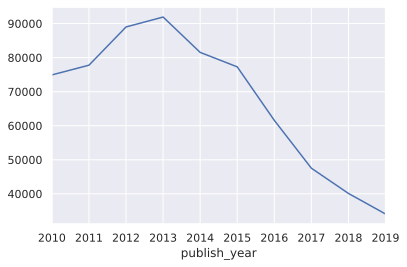

In [34]:
news_counts.plot()

<div class="alert alert-block alert-success">
<b>Insight Notes:</b>
    It can be firstly noticed the headlines covered in this dataset were rapidly decreased from 2013 which might affect our final analysis due to the unbalanced data in each year.       </div>

In [35]:
# remove the stopwords (meaningless words) in headline column
stop = stopwords.words('english')
# apply(lambda x:) means apply conditions in the specific column
headlines = abc['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[Stemming and Lemmatisation](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) are also conducted at the beginning. <br>However, it was found that it would make some words incomplete and some particular words cannot be figure out after cleaning. (e.g. bus -> bu, "wa" was removed)

In [36]:
# remove the number in headlines because the number does not contribute to the topic modelling in this analysis
regex_1 = r'[0-9]+[a-z]' 
regex_2 = r'[0-9]'
abc['headline_cleaned'] = headlines.str.replace(regex_1,'')
abc['headline_cleaned'] = abc['headline_cleaned'].str.replace(regex_2,'')

**Display the cleaned dataframe**

In [37]:
abc = abc[['publish_date','publish_year','headline_text','headline_cleaned']]
abc

,publish_date,publish_year,headline_text,headline_cleaned
0,20100101,2010,12m degas stolen from museum,degas stolen museum
1,20100101,2010,17 die in bangladesh bus crash,die bangladesh bus crash
2,20100101,2010,2010 to be drier after very wet 2009,drier wet
3,20100101,2010,37 catholic workers killed worldwide,catholic workers killed worldwide
4,20100101,2010,600 hurt in philippine new year revelry,hurt philippine new year revelry
...,...,...,...,...
675708,20191231,2019,vision of flames approaching corryong in victoria,vision flames approaching corryong victoria
675709,20191231,2019,wa police and government backflip on drug amne...,wa police government backflip drug amnesty bins
675710,20191231,2019,we have fears for their safety: victorian premier,fears safety: victorian premier
675711,20191231,2019,when do the 20s start,start


## 3. Analysis & Visualisation

**Natural Language Processing** problem is covered in this analysis, and we are mainly focus on **Topic Modelling** by using some relevant techniques as we are required to tag the top topics in analysis.

There are **FOUR** steps in this part:<br>
1) **General Analysis**: the word frequency will be counted throughout the cleaned headlines, and show the **most popular words** as a overview of the headlines by using *WordCloud*.<br>
2) **Topic Classifications**: *Naive Bayes Classifer* will be applied here to classify the topic for each healine and identify the specific **top topics**. <br>
3) **Topic Modelling**: *Non-Negative Matrix Factorization (NMF)* will be applied to identify the **top 10 topic cluster** with **top 10 words**. <br>
4) **Analysis Result Summary**

### 3.1 General Analysis

First, let's have a general view of what are the most popular words over the last 10 years?

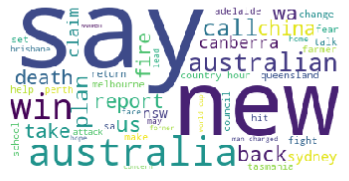

In [38]:
head = " ".join(abc['headline_cleaned'].values.tolist())
wordcloud = WordCloud(max_words = 50, background_color='white',stopwords=None).generate(head)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now that we have a rough view of the popular words over the last decade, but what are the exact frequencies of them?   
Let's identify the most-common 20 words based on their word frequencies.

In [39]:
headline_count = Counter(" ".join(abc['headline_cleaned'].values.tolist()).split())
headline_count.most_common(20)

[('police', 18498),
 ('new', 17903),
 ('man', 16980),
 ('says', 13681),
 ('interview', 12272),
 ('australia', 10876),
 ('australian', 9783),
 ('court', 9629),
 ('nsw', 9243),
 ('us', 8394),
 ('fire', 8230),
 ('government', 7730),
 ('wa', 7595),
 ('sydney', 7563),
 ('council', 7324),
 ('rural', 6841),
 ('death', 6636),
 ('day', 6636),
 ('charged', 6289),
 ('murder', 6162)]

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>From the wordcloud and the result of the most-common 20 words throughout the cleaned headlines, it is found that:<br>
<li>"police" is the top first word in the headlines, it might be related to the criminal justice issues linking to other popular words such as "court" and "murder", but it could also be related to the politics.
<li>"say" is highly frequent, this might give us information that there were lots of interviews ("interview" is another top word) or talkings from famous people. 
<li> "australia/australian" as well as some states and capital cities such as "nsw", "wa", "canberra", "sydney" appear a lot, which might mean abcnews put more emphasis on the statewide news and things happened in capital cities. 
<li>"fire" is another word draw our attentions due to the unprecedented bushfires started from 2019. 
<li>"china" was also a popular word as shown in wordcloud, it may due to the close trade relationship, or other political issues, or even international students or immigrants from china.
<br>However, we are not able to draw any conclusions here because we have not taken the specific headlines into account. The meanings of the words vary in different scenarios. Hence further analysis is needed as follows.</div>

### 3.2 Topic Classifications

So let's discover what specific topic it is belonging to headline by headline.  
Here, we are using Naive Bayes Classifier to help us categorise every healine into 20 news topics by applying machine learning techniques.    
* [20newsgroups](http://qwone.com/~jason/20Newsgroups/) is a dataset widely used for text classification or text cluster.

In [40]:
# fetch 20 news topics from 20newsgroups dataset

newsgroups_train = fetch_20newsgroups(subset='train')
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [41]:
# set the training and testing set with 20 news topics
headlines = [value[3] for value in abc.iloc[0:].values]
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [42]:
X_train_raw = train.data
y_train = train.target
X_test_raw = test.data
y_test = test.target
y_expected = test.target

In [43]:
# Extract textual features from text
vec = TfidfVectorizer()
X_train = vec.fit_transform( X_train_raw )
X_test = vec.fit_transform( X_test_raw )

In [44]:
# build the model and print the model accuracy
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train.data, train.target)
y_predicted  = model.predict(test.data)
print( 'The overall accuracy of the model is %.2f%%' %(accuracy_score( y_expected, y_predicted )*100))

The overall accuracy of the model is 77.39%


Text(80.90000000000005, 0.5, 'predicted label')

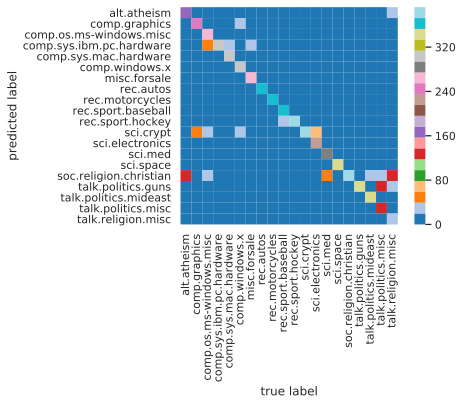

In [45]:
# plot the confusion matrix to evaluate the performance of the classification model
colormap = "tab20"
mat = confusion_matrix(test.target, y_predicted)
sns.heatmap(mat.T, square=True, annot=False, fmt='d', cbar=True, cmap = colormap,
            xticklabels=train.target_names, yticklabels=train.target_names)
#plt.figure(figsize=(10,6))  
plt.xlabel('true label')
plt.ylabel('predicted label')

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
From the result of the model accuracy and the confusion matrix, it can be noticed that most of the classifications can be categorised well, deviations mainly occured in the topics of "Science.Cryptography", "Social.Religien.Christian", "Talk.Politics.Guns" and "Computers". <br>So we should consider this situation as a gap when we propose our insights or recommendations to the stakeholders.</div>

In [46]:
def predict_category(s, train=train, model=model):
    topic_pred = model.predict([s])
    return train.target_names[topic_pred[0]]

In [47]:
Headline=[]
Topic=[]
for head in headlines:
    Headline.append(head)
    Topic.append(predict_category(head))
df = pd.DataFrame(list(zip(abc['publish_year'],Headline, Topic)), 
               columns =['Year','Headline', 'Topic']) 

Here is the result of the topic classification based on the model we build.

In [48]:
df

,Year,Headline,Topic
0,2010,degas stolen museum,talk.politics.mideast
1,2010,die bangladesh bus crash,comp.sys.ibm.pc.hardware
2,2010,drier wet,comp.os.ms-windows.misc
3,2010,catholic workers killed worldwide,soc.religion.christian
4,2010,hurt philippine new year revelry,rec.sport.baseball
...,...,...,...
675708,2019,vision flames approaching corryong victoria,rec.sport.hockey
675709,2019,wa police government backflip drug amnesty bins,sci.crypt
675710,2019,fears safety: victorian premier,talk.politics.guns
675711,2019,start,rec.sport.baseball


But how frequent of these topics over the last decade? Let's see..

In [49]:
count = df.groupby(['Year','Topic'])['Headline'].count().unstack()
topics = count.mean()
topics = topics.sort_values(ascending=False)

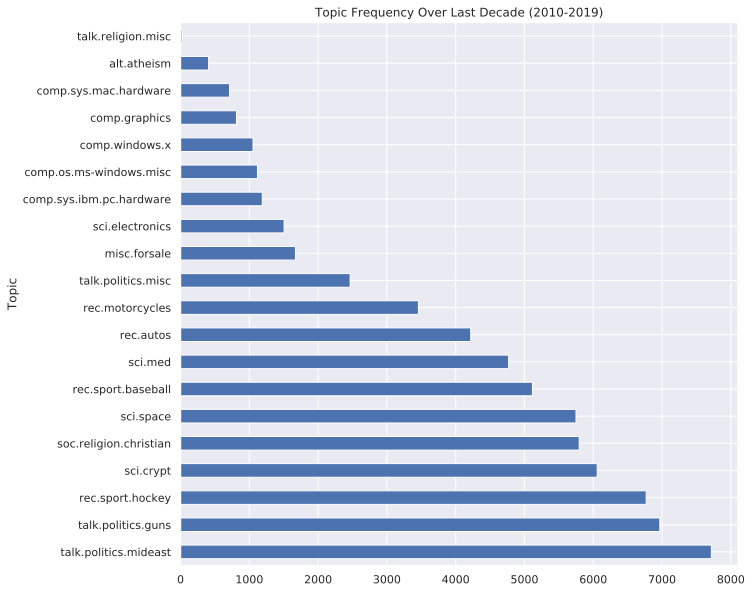

In [50]:
topics.plot(kind="barh",title = "Topic Frequency Over Last Decade (2010-2019)",figsize=(10,10))

In [51]:
print("It is obviously found that the top 10 topics are: ")
top = pd.DataFrame(topics[:10])
top.to_csv('Top Topics.csv')
top = pd.read_csv('Top Topics.csv')
top.rename(columns={'0':'Number of Topics'},inplace=True)
top

It is obviously found that the top 10 topics are: 


,Topic,Number of Topics
0,talk.politics.mideast,7716.5
1,talk.politics.guns,6967.1
2,rec.sport.hockey,6769.3
3,sci.crypt,6057.0
4,soc.religion.christian,5795.3
5,sci.space,5749.0
6,rec.sport.baseball,5116.0
7,sci.med,4770.2
8,rec.autos,4218.8
9,rec.motorcycles,3457.7


But were these topics being always the top topics in the past 10 years? Or some of them were only booming during special years?  
Then we could have a look at it through the table and chart below by years. In the table, the percentages of each topic occupied in each year are calculated, and the trend of each topic are displayed in the line chart.<br>
* *We use the percentages here rather than just counting the numbers of each topic in each year because as we have known from the plot at the beginning, the number of headlines in each year is quite different which will lead to a big deviations in the analysis.*

In [52]:
counts = (df.groupby(['Year','Topic'])['Headline'].count()*100/df.groupby(['Year'])['Headline'].count()).unstack()
counts.round(2)

Topic,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
Year,,,,,,,,,,,,,,,,,,,,
2010,0.56,1.06,1.64,1.62,0.94,1.61,2.46,6.73,5.91,8.68,9.72,8.85,2.07,6.99,7.95,8.73,10.46,10.24,3.77,0.02
2011,0.53,1.20,1.60,1.88,1.11,1.76,2.71,6.68,5.37,7.97,10.67,8.72,2.33,6.52,8.38,8.05,9.91,10.93,3.66,0.03
2012,0.56,1.12,1.65,1.89,1.14,1.77,2.64,6.41,5.05,7.74,10.83,9.42,2.33,6.73,8.81,7.94,9.91,10.61,3.43,0.02
2013,0.55,1.20,1.65,1.77,1.09,1.73,2.48,6.59,5.31,7.36,10.21,9.17,2.31,6.96,8.45,7.90,10.66,10.84,3.75,0.03
2014,0.66,1.27,1.59,1.90,1.11,1.55,2.55,6.11,4.86,7.49,10.44,8.87,2.34,7.46,8.86,7.94,9.73,11.80,3.45,0.02
2015,0.70,1.22,1.92,1.77,1.02,1.40,2.34,6.09,4.77,6.97,10.37,8.67,2.17,7.06,8.67,8.29,10.18,12.95,3.41,0.04
2016,0.61,1.19,1.67,1.67,0.96,1.31,2.34,6.00,4.81,6.85,9.07,9.18,2.18,7.40,8.81,9.21,10.73,11.91,4.05,0.06
2017,0.65,1.29,1.59,1.68,0.99,1.24,2.20,5.59,4.83,7.22,9.21,9.27,2.16,7.24,8.22,10.36,10.52,11.96,3.71,0.06
2018,0.65,1.29,1.58,1.54,1.12,1.32,2.40,5.62,5.16,7.89,8.76,8.66,1.97,7.51,8.11,10.16,10.49,12.09,3.64,0.05


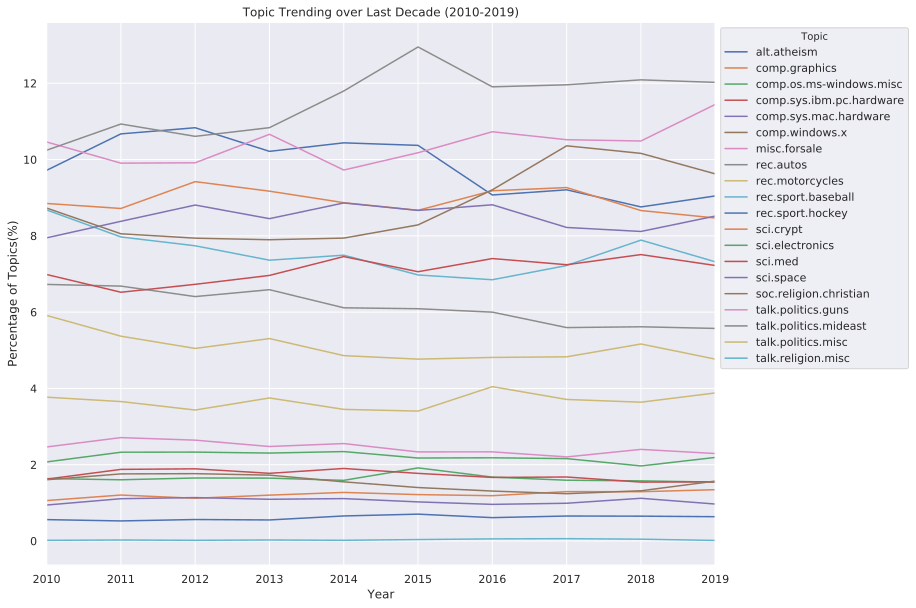

In [53]:
plot = counts.plot(ax=plt.axes(title="Topic Trending over Last Decade (2010-2019)",ylabel = "Percentage of Topics(%)"),figsize=(12,10) )
plot.get_legend().set_bbox_to_anchor((1, 1))

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
It can be noticed the trend of each topic is relatively stable within a timeframe specially for the least-common ones.  <br> 
Furthermore, responding to the top 10 topics throughout 10 years we get before, it is apparently known the topic of "politics.mideast" was always popular and even went to the peak point in 2015. After searching the internet about what was happening in the middle east in 2015, it was a crisis for the middle east in 2015 and the political situation there changed due to the regional conflicts, and the large numbers of people were dying during that period, all of these were enough to get the world's attention not even Australia.
</div>

*[What's happening in the Middle East and why it matters](https://edition.cnn.com/2015/01/23/middleeast/middle-east-country-breakdown/index.html)*

---
Incorporate with both "topic frequency" and the relatively stable "topic trending" over the last decade, we could have a clue about the top 10 topics. (The ranking would slightly change in different year.)

In [54]:
# to make the result clear to understand, the name of the orginal categories were made up without abbreviations.
top.rename(columns={'Topic':'Topic Category'},inplace=True)
top['Main Topic'] = top['Topic Category'].map(lambda x:x.split('.')[0])
top['Sub Topic'] = top['Topic Category'].map(lambda x:x.split('.')[1])
top['Main Topic'].replace(['talk','sci','soc','rec'],['Talk','Science','Sociology','Recreation'],inplace=True)
top['Sub Topic'].replace(['crypt','med'],['cryptography','medical'],inplace=True)
top = top[['Main Topic','Sub Topic','Topic Category','Number of Topics']]
top

,Main Topic,Sub Topic,Topic Category,Number of Topics
0,Talk,politics,talk.politics.mideast,7716.5
1,Talk,politics,talk.politics.guns,6967.1
2,Recreation,sport,rec.sport.hockey,6769.3
3,Science,cryptography,sci.crypt,6057.0
4,Sociology,religion,soc.religion.christian,5795.3
5,Science,space,sci.space,5749.0
6,Recreation,sport,rec.sport.baseball,5116.0
7,Science,medical,sci.med,4770.2
8,Recreation,autos,rec.autos,4218.8
9,Recreation,motorcycles,rec.motorcycles,3457.7


### 3.3 Topic Modelling
Even we know the top topics over the last decade, we are more curious about what were the conversation about in these topics?  
In this step with topic modelling technique by [NMF(Non-negative Matrix Factorization)](https://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/), we can dig more details of those popular topics.

<img src="img/why NMF.png" />
<center>Figure: Why NMF?</center>

In [59]:
# prepare for the NMF model: TF-IDF (Term Frequency — Inverse Document Frequency)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(headlines)

In [60]:
# select top 10 topics
num_topics = 10                                                                

In [61]:
# develop a NMF model
model = NMF(n_components=num_topics, init='nndsvd').fit(tfidf)

In [62]:
# generate NMF Topics
# obtain the most important scoring words in each cluster, and add them to a Dataframe
def get_nmf_topics(model, n_top_words):
    
    # the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    # feat_names = vectorizer.get_feature_names()
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [tfidf_feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

get_nmf_topics(model,10).T

,0,1,2,3,4,5,6,7,8,9
Topic # 01,interview,extended,michael,david,john,james,ben,smith,matt,andrew
Topic # 02,man,charged,murder,court,accused,dies,woman,crash,death,found
Topic # 03,rural,news,national,nsw,reporter,sa,exchange,qld,friday,thursday
Topic # 04,abc,weather,sport,business,news,entertainment,market,analysis,speaks,stories
Topic # 05,country,hour,nsw,tas,wa,august,drum,vic,october,september
Topic # 06,new,zealand,year,york,laws,hospital,years,centre,deal,home
Topic # 07,police,search,probe,investigate,missing,officer,car,crash,hunt,death
Topic # 08,says,australian,government,us,council,health,election,nsw,wa,report
Topic # 09,australia,day,world,one,south,cup,test,vs,first,two
Topic # 10,fire,house,sydney,crews,home,woman,destroys,suspicious,blaze,dies


<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
Here above, we get a dataframe describing the top 10 topics with top 10 words in each.  <br>
Generally, the topic words are matching with the wordcloud we have had in step 3.1, and the topic cluster can also be summarised linking to the top 10 topics we conclude in step 3.2.                                                                                      
</div>

### 3.4 Analysis Result Summary

Finally, according to the results from 3.1 to 3.3, we could have a more comprehensive view of the top topics including the topic words about the abcnews during 2010-2019.

<img src="img/Q3 Summary.jpg" />

After this, we can incorporate with the results from 3.1 to 3.3 to draw some meaningful insights overall.

## 4. Insights

Some insights can be initiated based on the analysis results in section 3.
- Topics about the politics, recreation, science and sociology were the top topics in ABC News from 2010 to 2019. 
- The topic trend was relatively stable throughout the last 10 years except for the booming topic of middle east politics in 2015 due to the crisis in those areas.
- Politics were the hot topics in ABC News indeed. The political news about the middle east was always being the top 3 topics over the last decade. Meanwhile, the political news about the US, New Zealand and China were involved in the national conversations as well. Even the news about politicians was also very popular on ABC News.  
    This might give some hints for the stakeholder to develop their own social media page: they could add some comments on political news. However, this should be considered seriously as a "WeMedia" talking about serious and sensitive political topics.
- The interview was one of the most popular forms of news. The stakeholder could refer to this form in their social media page by increasing the number of interviews to attract more readers.
- Science and sociology topics such as the criminal justice related issues, the "fire" (might be bushfire), the medical issues drew lots of attentions because these kinds of news are closely connected to people's lives not only in Australia but also any other countries around the worlds. So for the stakeholder in this analysis, it is also crucial to keep eyes on these topics which people really care about.  
- It can also be noticed the statewide and national wide news or the news happened in capital cities were widely discussed in news. So for the stakeholder, more discussions on the high-impact events can attract more readers.
- "police" and "court" were quite frequently mentioned in the conversations which means it might be a good idea to introduce some legal knowledge and organise some interviews with legal staff on the page. 
- If the stakeholder decides to focus on the recreation topics, that would be a good start as well especially starting from sports such as hockey. Reviews about the live games would get more clicks and hits in the page according to the top topic words "vs", "live" and "cup".

**Limitations and Future Work** <br>
The top topics with popular words analysed in this report offer the stakeholder a good direction of developing their new social media page. However, this analysis is based on the news from ABC News only, which means the range of the data is a bit narrow and it might affect the analysis result. Further, the data is only from the news headlines without taking the contents into account which would also have impacts on the effectiveness of the analysis. Moreover, to really figure out what kind of topics and contents are more attractive, the number of readers of each news should also be considered. Finally, the accuracy of this model can be improved as well, even different techniques applied in the analysis might lead to  a differnt analysis result. So, to have more accurate and critical analysis results for the stakeholder, future work needs to be executed as listed below.
- Collect more data from a wide range of news medias such as The Age, The Guardian, etc.
- Take the news headlines, contents and the number of readers into account in the analysis to lead a more accurate analysis for the stakehorlder.
- The performance of the model can be improved by further testing with adjustments of some parameters.
- Analysis results should be evaluated before final release.